In [25]:
razor.api.libraries('fastparquet')


Name,Technology,Install Status,Created by,Created on,Modified by,Modified on
fastparquet,PYTHON,INSTALLED,Ayan Basak,"Sep 25, 2020",Ayan Basak,"Sep 25, 2020"


In [26]:
import razor


In [27]:
config = {'cpu': 8 , 'ram': 36000}

In [28]:
# General imports
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random

# custom imports
from multiprocessing import Pool        # Multiprocess Runs

warnings.filterwarnings('ignore')

In [29]:
import razor.flow as rf
from razor.api import datasources
from razor import project_space_path
import razor
from razor import Technology, LibraryMode


In [30]:
import typing as t

# Light GBM modelling

In [31]:
# #################################################################################
# ## Seeder
# # :seed to make all processes deterministic     # type: int
# def seed_everything(seed=0):
#     random.seed(seed)
#     np.random.seed(seed)

    
# ## Multiprocess Runs
# def df_parallelize_run(func, t_split):
#     num_cores = np.min([N_CORES,len(t_split)])
#     pool = Pool(num_cores)
#     df = pd.concat(pool.map(func, t_split), axis=1)
#     pool.close()
#     pool.join()
#     return df

In [8]:
# ########################### Helper to load data by store ID
# #################################################################################
# # Read data
# def get_data_by_store(store):
    
#     # Read and contact basic feature
#     df = pd.concat([pd.read_pickle(BASE),
#                     pd.read_pickle(PRICE).iloc[:,2:],
#                     pd.read_pickle(CALENDAR).iloc[:,2:]],
#                     axis=1)
    
#     # Leave only relevant store
#     df = df[df['store_id']==store]

#     # With memory limits we have to read 
#     # lags and mean encoding features
#     # separately and drop items that we don't need.
#     # As our Features Grids are aligned 
#     # we can use index to keep only necessary rows
#     # Alignment is good for us as concat uses less memory than merge.
#     df2 = pd.read_pickle(MEAN_ENC)[mean_features]
#     df2 = df2[df2.index.isin(df.index)]
    
#     df3 = pd.read_pickle(LAGS).iloc[:,3:]
#     df3 = df3[df3.index.isin(df.index)]
    
#     df = pd.concat([df, df2], axis=1)
#     del df2 # to not reach memory limit 
    
#     df = pd.concat([df, df3], axis=1)
#     del df3 # to not reach memory limit 
    
#     # Create features list
#     features = [col for col in list(df) if col not in remove_features]
#     df = df[['id','d',TARGET]+features]
    
#     # Skipping first n rows
#     df = df[df['d']>=START_TRAIN].reset_index(drop=True)
    
#     return df, features

# # Recombine Test set after training
# def get_base_test():
#     base_test = pd.DataFrame()

#     for store_id in STORES_IDS:
#         temp_df = pd.read_pickle('test_'+store_id+'.pkl')
#         temp_df['store_id'] = store_id
#         base_test = pd.concat([base_test, temp_df]).reset_index(drop=True)
    
#     return base_test


# ########################### Helper to make dynamic rolling lags
# #################################################################################
# def make_lag(LAG_DAY):
#     lag_df = base_test[['id','d',TARGET]]
#     col_name = f'sales_lag_{str(LAG_DAY)}'
#     lag_df[col_name] = lag_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(LAG_DAY)).astype(np.float16)
#     return lag_df[[col_name]]


# def make_lag_roll(LAG_DAY):
#     shift_day = LAG_DAY[0]
#     roll_wind = LAG_DAY[1]
#     lag_df = base_test[['id','d',TARGET]]
#     col_name = f'rolling_mean_tmp_{str(shift_day)}_{str(roll_wind)}'
#     lag_df[col_name] = lag_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(shift_day).rolling(roll_wind).mean())
#     return lag_df[[col_name]]



In [9]:
# ########################### Model params
# #################################################################################
# import lightgbm as lgb
# lgb_params = {
#                     'boosting_type': 'gbdt',
#                     'objective': 'tweedie',
#                     'tweedie_variance_power': 1.1,
#                     'metric': 'rmse',
#                     'subsample': 0.5,
#                     'subsample_freq': 1,
#                     'learning_rate': 0.03,
#                     'num_leaves': 2**11-1,
#                     'min_data_in_leaf': 2**12-1,
#                     'feature_fraction': 0.5,
#                     'max_bin': 100,
#                     'n_estimators': 1400,
#                     'boost_from_average': False,
#                     'verbose': -1,
#                 } 



In [10]:
# ########################### Vars
# #################################################################################
# VER = 1                          # Our model version
# SEED = 42                        # We want all things
# seed_everything(SEED)            # to be as deterministic 
# lgb_params['seed'] = SEED        # as possible
# N_CORES = psutil.cpu_count()     # Available CPU cores


# #LIMITS and const
# TARGET      = 'sales'            # Our target
# START_TRAIN = 0                  # We can skip some rows (Nans/faster training)
# END_TRAIN   = 1913               # End day of our train set
# P_HORIZON   = 28                 # Prediction horizon
# USE_AUX     = True               # Use or not pretrained models

# #FEATURES to remove
# ## These features lead to overfit
# ## or values not present in test set
# remove_features = ['id','state_id','store_id',
#                    'date','wm_yr_wk','d', TARGET]
# mean_features   = ['enc_cat_id_mean','enc_cat_id_std',
#                    'enc_dept_id_mean','enc_dept_id_std',
#                    'enc_item_id_mean','enc_item_id_std'] 


# base_df = pd.read_csv(project_space_path("M5Forecasting/sales_train_validation.csv"))
# price_df = pd.read_csv(project_space_path("M5Forecasting/sell_prices.csv"))
# calendar_df = pd.read_csv(project_space_path("M5Forecasting/calendar.csv"))

# base_df.to_pickle(project_space_path('M5Forecasting/m5-simple-fe/grid_part_1.pkl'))
# price_df.to_pickle(project_space_path('M5Forecasting/m5-simple-fe/grid_part_2.pkl'))
# calendar_df.to_pickle(project_space_path('M5Forecasting/m5-simple-fe/grid_part_3.pkl'))

# #PATHS for Features
# ORIGINAL = project_space_path("M5Forecasting")+"/"
# BASE     = project_space_path('M5Forecasting/m5-simple-fe/grid_part_1.pkl')
# PRICE    = project_space_path('M5Forecasting/m5-simple-fe/grid_part_2.pkl')
# CALENDAR = project_space_path('M5Forecasting/m5-simple-fe/grid_part_3.pkl')
# LAGS     = project_space_path('M5Forecasting/m5-lags-features/lags_df_28.pkl')
# MEAN_ENC = project_space_path('M5Forecasting/m5-custom-features/mean_encoding_df.pkl')


# # AUX(pretrained) Models paths
# AUX_MODELS = '../input/m5-aux-models/'


# #STORES ids
# STORES_IDS = pd.read_csv(ORIGINAL+'sales_train_validation.csv')['store_id']
# STORES_IDS = list(STORES_IDS.unique())


# #SPLITS for lags creation
# SHIFT_DAY  = 28
# N_LAGS     = 15
# LAGS_SPLIT = [col for col in range(SHIFT_DAY,SHIFT_DAY+N_LAGS)]
# ROLS_SPLIT = []
# for i in [1,7,14]:
#     for j in [7,14,30,60]:
#         ROLS_SPLIT.append([i,j])
        


In [11]:
# ########################### Aux Models
# # If you don't want to wait hours and hours
# # to have result you can train each store 
# # in separate kernel and then just join result.

# # If we want to use pretrained models we can 
# ## skip training 
# ## (in our case do dummy training
# ##  to show that we are good with memory
# ##  and you can safely use this (all kernel) code)
# if USE_AUX:
#     lgb_params['n_estimators'] = 2

In [12]:
# ########################### Train Models
# #################################################################################
# for store_id in STORES_IDS:
#     print('Train', store_id)
    
#     # Get grid for current store
#     grid_df, features_columns = get_data_by_store(store_id)
    
#     # Masks for 
#     # Train (All data less than 1913)
#     # "Validation" (Last 28 days - not real validatio set)
#     # Test (All data greater than 1913 day, 
#     #       with some gap for recursive features)
#     train_mask = grid_df['d']<=END_TRAIN
#     valid_mask = train_mask&(grid_df['d']>(END_TRAIN-P_HORIZON))
#     preds_mask = grid_df['d']>(END_TRAIN-100)
    
#     train_data = lgb.Dataset(grid_df[train_mask][features_columns], 
#                        label=grid_df[train_mask][TARGET])
#     train_data.save_binary(project_space_path("M5Forecasting/train_data.bin"))
#     train_data = lgb.Dataset(project_space_path("M5Forecasting/train_data.bin"))
    
#     valid_data = lgb.Dataset(grid_df[valid_mask][features_columns], 
#                        label=grid_df[valid_mask][TARGET])
    
#     # Saving part of the dataset for later predictions
#     # Removing features that we need to calculate recursively 
#     grid_df = grid_df[preds_mask].reset_index(drop=True)
#     keep_cols = [col for col in list(grid_df) if '_tmp_' not in col]
#     grid_df = grid_df[keep_cols]
#     grid_df.to_pickle(project_space_path(f"M5Forecasting/test_{store_id}.pkl"))
#     del grid_df
    
#     # Launch seeder again to make lgb training 100% deterministic
#     # with each "code line" np.random "evolves" 
#     # so we need (may want) to "reset" it
#     seed_everything(SEED)
#     estimator = lgb.train(lgb_params,
#                           train_data,
#                           valid_sets = [valid_data],
#                           verbose_eval = 100,
#                           )
    
#     # Save model - it's not real '.bin' but a pickle file
#     # estimator = lgb.Booster(model_file='model.txt')
#     # can only predict with the best iteration (or the saving iteration)
#     # pickle.dump gives us more flexibility
#     # like estimator.predict(TEST, num_iteration=100)
#     # num_iteration - number of iteration want to predict with, 
#     # NULL or <= 0 means use best iteration
#     model_name = 'lgb_model_'+store_id+'_v'+str(VER)+'.bin'
#     pickle.dump(estimator, open(project_space_path(f"M5Forecasting/{model_name}", 'wb'))

#     # Remove temporary files and objects 
#     # to free some hdd space and ram memory
# #     !rm train_data.bin
                
#     del train_data, valid_data, estimator
#     gc.collect()
    
#     # "Keep" models features for predictions
#     MODEL_FEATURES = features_columns
                

In [13]:
lib1 = razor.api.libraries(name='lightgbm').artifact()

In [14]:
@rf.block(executor=rf.ContainerExecutor(cores=config['cpu'], memory=config['ram']))
class Train:
#     config: t.Any
    
    __libs__ = [lib1]
    
    def init(self):
        #PATHS for Features
        self.ORIGINAL = project_space_path("M5Forecasting")+"/"
        self.BASE     = project_space_path('M5Forecasting/m5-simple-fe/grid_part_1 .pkl')
        self.PRICE    = project_space_path('M5Forecasting/m5-simple-fe/grid_part_2.pkl')
        self.CALENDAR = project_space_path('M5Forecasting/m5-simple-fe/grid_part_3.pkl')
        self.LAGS     = project_space_path('M5Forecasting/lags_df_28.pkl')
        self.MEAN_ENC = project_space_path('M5Forecasting/mean_encoding_df.pkl')

        #LIMITS and const
        self.TARGET      = 'sales'            # Our target
        self.START_TRAIN = 0                  # We can skip some rows (Nans/faster training)
        self.END_TRAIN   = 1913               # End day of our train set
        self.P_HORIZON   = 28                 # Prediction horizon
        self.USE_AUX     = False               # Use or not pretrained models
        self.N_CORES = psutil.cpu_count()     # Available CPU cores

        # AUX(pretrained) Models paths
        self.AUX_MODELS = '../input/m5-aux-models/'


        #STORES ids
        self.STORES_IDS = pd.read_csv(self.ORIGINAL+'sales_train_validation.csv')['store_id']
        self.STORES_IDS = list(self.STORES_IDS.unique())


        #SPLITS for lags creation
        self.SHIFT_DAY  = 28
        self.N_LAGS     = 15
        self.LAGS_SPLIT = [col for col in range(self.SHIFT_DAY, self.SHIFT_DAY + self.N_LAGS)]
        
        self.remove_features = ['id','state_id','store_id',
                           'date','wm_yr_wk','d', self.TARGET]
        self.mean_features   = ['enc_cat_id_mean','enc_cat_id_std',
                           'enc_dept_id_mean','enc_dept_id_std',
                           'enc_item_id_mean','enc_item_id_std'] 

            
    def seed_everything(self, seed=0):
        random.seed(seed)
        np.random.seed(seed)


    ## Multiprocess Runs
    def df_parallelize_run(self, func, t_split):
        num_cores = np.min([self.N_CORES,len(t_split)])
        pool = Pool(num_cores)
        df = pd.concat(pool.map(func, t_split), axis=1)
        pool.close()
        pool.join()
        return df

    def get_data_by_store(self, store):

        # Read and contact basic feature
        df1 = pd.read_pickle(self.BASE)
#         df1 = df1[df1['store_id']==store]
        df2 = pd.read_pickle(self.PRICE).iloc[:,2:]
#         df2 = df2[df2['store_id']==store]
        df3 = pd.read_pickle(self.CALENDAR).iloc[:,2:]
        df = pd.concat([df1, df2, df3],
                        axis=1)

        # Leave only relevant store
        df = df[df['store_id']==store]

        # With memory limits we have to read 
        # lags and mean encoding features
        # separately and drop items that we don't need.
        # As our Features Grids are aligned 
        # we can use index to keep only necessary rows
        # Alignment is good for us as concat uses less memory than merge.
        df2 = pd.read_pickle(self.MEAN_ENC)[self.mean_features]
        df2 = df2[df2.index.isin(df.index)]

        df = pd.concat([df, df2], axis=1)
        del df2 # to not reach memory limit 
        gc.collect()

        df3 = pd.read_pickle(self.LAGS).iloc[:,3:]
        df3 = df3[df3.index.isin(df.index)]


        df = pd.concat([df, df3], axis=1)
        del df3 # to not reach memory limit 
        gc.collect()

        # Create features list
        features = [col for col in list(df) if col not in self.remove_features]
        df = df[['id','d',self.TARGET]+features]

        # Skipping first n rows
        df = df[df['d']>=self.START_TRAIN].reset_index(drop=True)

        return df, features

    # Recombine Test set after training
    def get_base_test(self):
        base_test = pd.DataFrame()

        for store_id in self.STORES_IDS:
            temp_df = pd.read_pickle('test_'+store_id+'.pkl')
            temp_df['store_id'] = store_id
            base_test = pd.concat([base_test, temp_df]).reset_index(drop=True)

        return base_test


    ########################### Helper to make dynamic rolling lags
    #################################################################################
    def make_lag(self, LAG_DAY):
        lag_df = base_test[['id','d',self.TARGET]]
        col_name = f'sales_lag_{str(LAG_DAY)}'
        lag_df[col_name] = lag_df.groupby(['id'])[self.TARGET].transform(lambda x: x.shift(LAG_DAY)).astype(np.float16)
        return lag_df[[col_name]]


    def make_lag_roll(self, LAG_DAY):
        shift_day = LAG_DAY[0]
        roll_wind = LAG_DAY[1]
        lag_df = base_test[['id','d',self.TARGET]]
        col_name = f'rolling_mean_tmp_{str(shift_day)}_{str(roll_wind)}'
        lag_df[col_name] = lag_df.groupby(['id'])[self.TARGET].transform(lambda x: x.shift(shift_day).rolling(roll_wind).mean())
        return lag_df[[col_name]]
    
    def run(self):
                         
        import logging


        import lightgbm as lgb
        lgb_params = {
                            'boosting_type': 'gbdt',
                            'objective': 'tweedie',
                            'tweedie_variance_power': 1.1,
                            'metric': 'rmse',
                            'subsample': 0.5,
                            'subsample_freq': 1,
                            'learning_rate': 0.03,
                            'num_leaves': 2**11-1,
                            'min_data_in_leaf': 2**12-1,
                            'feature_fraction': 0.5,
                            'max_bin': 100,
                            'n_estimators': 1400,
                            'boost_from_average': False,
                            'verbose': -1,
                        } 


                ########################### Vars
        #################################################################################
        VER = 1                          # Our model version
        SEED = 42                      
        self.seed_everything(SEED)      
        lgb_params['seed'] = SEED        

        #FEATURES to remove
        ## These features lead to overfit
        ## or values not present in test set



#         base_df = pd.read_csv(project_space_path("M5Forecasting/sales_train_validation.csv"))
#         price_df = pd.read_csv(project_space_path("M5Forecasting/sell_prices.csv"))
#         calendar_df = pd.read_csv(project_space_path("M5Forecasting/calendar.csv"))

#         base_df.to_pickle(project_space_path('M5Forecasting/m5-simple-fe/grid_part_1.pkl'))
#         price_df.to_pickle(project_space_path('M5Forecasting/m5-simple-fe/grid_part_2.pkl'))
#         calendar_df.to_pickle(project_space_path('M5Forecasting/m5-simple-fe/grid_part_3.pkl'))

        ROLS_SPLIT = []
        
        for i in [1,7,14]:
            for j in [7,14,30,60]:
                ROLS_SPLIT.append([i,j])


        if self.USE_AUX:
            lgb_params['n_estimators'] = 2

        

                ########################### Train Models
        #################################################################################
        for store_id in self.STORES_IDS:
            logging.info('Train')
            logging.info(store_id)

            # Get grid for current store
            grid_df, features_columns = self.get_data_by_store(store_id)
            
            logging.info("Loaded grid Data")

            # Masks for 
            # Train (All data less than 1913)
            # "Validation" (Last 28 days - not real validatio set)
            # Test (All data greater than 1913 day, 
            #       with some gap for recursive features)
            train_mask = grid_df['d']<=self.END_TRAIN
            valid_mask = train_mask&(grid_df['d']>(self.END_TRAIN-self.P_HORIZON))
            preds_mask = grid_df['d']>(self.END_TRAIN-100)

            train_data = lgb.Dataset(grid_df[train_mask][features_columns], 
                               label=grid_df[train_mask][self.TARGET])
            
#             train_data.save_binary(project_space_path("M5Forecasting/train_data.bin"))
#             train_data = lgb.Dataset(project_space_path("M5Forecasting/train_data.bin"))

            valid_data = lgb.Dataset(grid_df[valid_mask][features_columns], 
                               label=grid_df[valid_mask][self.TARGET])

            # Saving part of the dataset for later predictions
            # Removing features that we need to calculate recursively 
            grid_df = grid_df[preds_mask].reset_index(drop=True)
            keep_cols = [col for col in list(grid_df) if '_tmp_' not in col]
            grid_df = grid_df[keep_cols]
            grid_df.to_pickle(project_space_path(f"M5Forecasting/test_{store_id}.pkl"))
            del grid_df
            gc.collect()

            # Launch seeder again to make lgb training 100% deterministic
            # with each "code line" np.random "evolves" 
            # so we need (may want) to "reset" it
            self.seed_everything(SEED)
            estimator = lgb.train(lgb_params,
                                  train_data,
                                  valid_sets = [valid_data],
                                  verbose_eval = 100,
                                  )


            model_name = 'lgb_model_'+store_id+'_v'+str(VER)+'.bin'
            pickle.dump(estimator, open(project_space_path(f"M5Forecasting/{model_name}"), 'wb'))

            # Remove temporary files and objects 
            # to free some hdd space and ram memory

#             os.remove()
            del train_data, valid_data, estimator
            gc.collect()

            # "Keep" models features for predictions
            MODEL_FEATURES = features_columns



In [15]:
train = Train()


In [16]:
p = rf.Pipeline("Train", targets=[train])  #preprocess


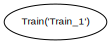

In [17]:
p

In [18]:
# lib1 = razor.api.libraries(name='lightgbm').artifact()


In [19]:
deployed_pipeline = razor.api.engines('DS-engine').execute(pipeline=p)


In [20]:
deployed_pipeline


PlatformPipelineRun(project_id='c0b26d85-a4c9-44f5-9d0e-f540dd2de644', pipeline_id='65966448-0236-11eb-a769-0242ac11000d', pipeline_name='Train', pipeline_run_id='b4b3cc1b-03f3-4785-bf99-12cbac64efba', pipeline_version=None, comment=None, created_on='2020-09-29T09:30:22.471+00:00', start_time=None, end_time=None, eta=0, run_at=1601371822471, run_duration=0, compute_time=0, wait_time=-233, ran_by_user=RanByUser(user_name='souryadipta das', email='souryadipta.das@razorthink.com'), status='IN_PROGRESS', block_status=[PlatformPipelineBlockRun(pipeline_run_id='b4b3cc1b-03f3-4785-bf99-12cbac64efba', pipeline_name='Train', pipeline_status='IN_PROGRESS', block_id='3ceccabe-9357-4891-b7ce-255cda2a719f', block_run_id='db8174cb-b66d-48da-870c-ecaf9ca299e1', block_name='Train_1', resource_spec=ResourceAllocated(cores=8, memory=20000, use_gpu=False, gpu=0, use_gpu_if_available=False, cluster_configuration={'worker': None, 'workerCore': None, 'workerMemory': None, 'numberOfInstances': None, 'maxServerCount': None}, additional_env={}, run_env='PYTHON'), technology='PYTHON', status='READY_TO_GO', containers=[], cluster_id='3ceccabe-9357-4891-b7ce-255cda2a719f', _log=None, _metric=None, wait_time=0, compute_time=0, start_time=None, end_time=None, queued_at='2020-09-29T09:30:23.000+00:00')], run_number=165, pipeline_variable_list=[], block_run_details=[BlockRunDetail(block_id='3ceccabe-9357-4891-b7ce-255cda2a719f', block_run_id='db8174cb-b66d-48da-870c-ecaf9ca299e1', block_name='Train_1', technology='PYTHON', log_path=None, input_parameters='{}', output_parameters=None, status='READY_TO_GO', created_at='2020-09-29T09:30:22.563+00:00', queued_at='2020-09-29T09:30:23.000+00:00', start_time=None, end_time=None, compute_time=0, wait_time=0, run_time=0, block_run_output_list=[], resource_allocated=ResourceAllocated(cores=8, memory=20000, use_gpu=False, gpu=0, use_gpu_if_available=False, cluster_configuration={'worker': None, 'workerCore': None, 'workerMemory': None, 'numberOfInstances': None, 'maxServerCount': None}, additional_env={}, run_env='PYTHON'))], pipeline_json='{\n  "id": "65966448-0236-11eb-a769-0242ac11000d",\n  "projectId": "c0b26d85-a4c9-44f5-9d0e-f540dd2de644",\n  "name": "Train",\n  "description": "",\n  "blocks": [\n    {\n      "name": "Train_1",\n      "id": "3ceccabe-9357-4891-b7ce-255cda2a719f",\n      "artifact_id": null,\n      "class_name": "Train",\n      "code": "eJyVWc1zG8l1ny8AA5AEQZAiRWlXK2+0Dte75PJbks3ShgIprQwRkkXuKtqKqj1ADzAABxhoZiCRG0DrLX2XR1VJPDnYiVNklSuX5Ja4ytf4X/A5qeTg+JBcklsu3vxeD0CCErWVEIVGz+vXb7rf93v8kfaXPzstib9gomQ7Ld6slrZtc6ZvHgaTzDWtXe4avsm8bdM2fafBSrbheeFPwilLCsZY3dg+bi3Qi62q7VcbXhho/m7TBDCIbblGtRFaypSlTVkJS7diQdwp1sySj+UnYScMEoxxp8RYWPCCs0tLi3xudnbJnCvyxaXi3IXF5Tk+u8gXzAvz80sXimHBD29h11SQYqzu8JZtYmeg4wHv6U7tatHD9K7AS+LJNdzdazwMzs0v8tmlcnF++sLFueXpRT6/NH1hbv789Pz5ZXPpPJ8tli4ALdPd8pnpelWnIXYuny+ZRml2aXpxfplPL5YuGtPG7PLF6ZJZnFtYmi3NLc8vhC0j0KqNqh+CT2lWrto2K7caJR9EutwbPuSeWAIY0CHWZR3r8U3POdzcoocnuO9UXs5L+Cbyudx/+hKXH8lcmZDaEpPxpD6SMVMw08RMxSwmZhpmcTGLYZYQszjXMSZ4EqPOUxiTfABjig9iHPAH94b2iXKaD2Ec9jN7I22pJvP0hLQv8+FJWsv6o4Bl98b2JUEzKyic4BmM43yEZx9L/gQwTnS/4xPSI2Utwj3JR/kYH+Yn+DgnnEQlAegkP8kn+Sl+mr/F367EATnFpU0pnCoEQxtLVxzXLBkeGFQJA/mjMPjgCOyj+tK0V603bXO6bH5UcaucNQ3XZ3NnZ5rbdhh85/+EPf//QV6IkN86imwbFY/xMpu/EC2/+wot02gws1FyOJ6AFyHFPMM2vTAvbewm8m+9CCZmZj6qNpotn95ttHamoeam7eHWpwQm88mk2H3DrnKDVGum5N2Hxng+XsWqPMwPW+cijVHyan4zl6lAZnf1jtyW/1y5p4Gr778fKDOzYaCWHDt8GgbvrFSbu77lNKbFi6fnFqcvLhql5aX52fJcsXgpDFIrdtXzS069eSnMn8spcSJCphicERY+Q2o/s2I7JcP2Ls30YQcKjkSnI49CUw2nhqPRH9TZrssebEOigA6DL6xk+EBhxKcwSPdBPJ/MkgDcbPbhDPeDDpGqvll/BakHIiQfbiHbdB3yQsxrGiUTQvUtnOnGrWtXrxVWr+OUl1c31yGcm7eu5dbJHlevrxfWVnFh7frq1U1ANtZXC2y9kAuD+NbqravrW2EwsInZFtu6tXqtEAZJbDiY32SfgPjnNzBPfLq5zlY//WNsbHotvwodSJaaLVZyWg0fywWWu3FrHa9IAYlt3Fhbv44HpUlsdE2DMyHv1OYWYbFra1jUiN+g12pU77XA3OTmJ9eubLG11TsAFlh04phrNCpYTNEj27x5/RqOPOyadee+ycqm4bdc6GEwJNT04BlkNc+0y3BE1pJ1Op/IzUhKWk71Pmpc7n0w18bljEbzs0pczsgaPl1F+f7X+COHPMDA7dK2USHPXSB/3TDqNLdGW8+6zj1RsZ0iNIkerKvBu67xheP

In [21]:
razor.api.engines('DS-engine').health()

PlatformEngineHealthList(slave_usage_array=[PlatformEngineHealth(server_ip='172.16.104.139', server_type='INFRASTRUCTURE', server_usage_info=[ServerUsageInfo(label='Current cpu usage', graph_type='bar', unit='', total=16, used=5, available=11, value='CORE'), ServerUsageInfo(label='Current memory usage', graph_type='bar', unit='GB', total=40802189312.0, used=5368709120.0, available=35433480192.0, value='RAM'), ServerUsageInfo(label='Current gpu usage', graph_type='bar', unit='', total=0, used=0, available=0, value='GPU')]), PlatformEngineHealth(server_ip='172.16.114.99', server_type='TECHNOLOGY', server_usage_info=[ServerUsageInfo(label='Current cpu usage', graph_type='bar', unit='', total=32, used=7, available=25, value='CORE'), ServerUsageInfo(label='Current memory usage', graph_type='bar', unit='GB', total=123480309760.0, used=37849399296.0, available=85630910464.0, value='RAM'), ServerUsageInfo(label='Current gpu usage', graph_type='bar', unit='', total=0, used=0, available=0, value='GPU')])])

In [22]:
razor.api.engines('DS-engine').queue()

Block,Pipeline,Wait Time(hours:minutes:seconds)
Train_1,Train,0:00:00


In [9]:
lib1 = razor.api.libraries(name='lightgbm').artifact()

In [32]:
@rf.block(executor=rf.ContainerExecutor(cores=config['cpu'], memory=config['ram']))
class Infer:
#     config: t.Any
    
    __libs__ = [lib1]
    
    def init(self):
        self.VER = 1                          # Our model version
        self.SEED = 42  
        
        #PATHS for Features
        self.ORIGINAL = project_space_path("M5Forecasting")+"/"
        self.BASE     = project_space_path('M5Forecasting/m5-simple-fe/grid_part_1 .pkl')
        self.PRICE    = project_space_path('M5Forecasting/m5-simple-fe/grid_part_2.pkl')
        self.CALENDAR = project_space_path('M5Forecasting/m5-simple-fe/grid_part_3.pkl')
        self.LAGS     = project_space_path('M5Forecasting/lags_df_28.pkl')
        self.MEAN_ENC = project_space_path('M5Forecasting/mean_encoding_df.pkl')

        #LIMITS and const
        self.TARGET      = 'sales'            # Our target
        self.START_TRAIN = 0                  # We can skip some rows (Nans/faster training)
        self.END_TRAIN   = 1913               # End day of our train set
        self.P_HORIZON   = 28                 # Prediction horizon
        self.USE_AUX     = False               # Use or not pretrained models
        self.N_CORES = psutil.cpu_count()     # Available CPU cores

        # AUX(pretrained) Models paths
        self.AUX_MODELS = './M5Forecasting/m5-aux-models/'


        #STORES ids
        self.STORES_IDS = pd.read_csv(self.ORIGINAL+'sales_train_validation.csv')['store_id']
        self.STORES_IDS = list(self.STORES_IDS.unique())


        #SPLITS for lags creation
        self.SHIFT_DAY  = 28
        self.N_LAGS     = 15
        self.LAGS_SPLIT = [col for col in range(self.SHIFT_DAY, self.SHIFT_DAY + self.N_LAGS)]
        
        self.remove_features = ['id','state_id','store_id',
                           'date','wm_yr_wk','d', self.TARGET]
        self.mean_features   = ['enc_cat_id_mean','enc_cat_id_std',
                           'enc_dept_id_mean','enc_dept_id_std',
                           'enc_item_id_mean','enc_item_id_std'] 

            
    def seed_everything(self, seed=0):
        random.seed(seed)
        np.random.seed(seed)


    ## Multiprocess Runs
    def df_parallelize_run(self, func, t_split):
        num_cores = np.min([self.N_CORES,len(t_split)])
        pool = Pool(num_cores)
        df = pd.concat(pool.map(func, t_split), axis=1)
        pool.close()
        pool.join()
        return df

    def get_data_by_store(self, store):

        # Read and contact basic feature
        df1 = pd.read_pickle(self.BASE)
#         df1 = df1[df1['store_id']==store]
        df2 = pd.read_pickle(self.PRICE).iloc[:,2:]
#         df2 = df2[df2['store_id']==store]
        df3 = pd.read_pickle(self.CALENDAR).iloc[:,2:]
        df = pd.concat([df1, df2, df3],
                        axis=1)

        # Leave only relevant store
        df = df[df['store_id']==store]

        # With memory limits we have to read 
        # lags and mean encoding features
        # separately and drop items that we don't need.
        # As our Features Grids are aligned 
        # we can use index to keep only necessary rows
        # Alignment is good for us as concat uses less memory than merge.
        df2 = pd.read_pickle(self.MEAN_ENC)[self.mean_features]
        df2 = df2[df2.index.isin(df.index)]

        df = pd.concat([df, df2], axis=1)
        del df2 # to not reach memory limit 
        gc.collect()

        df3 = pd.read_pickle(self.LAGS).iloc[:,3:]
        df3 = df3[df3.index.isin(df.index)]


        df = pd.concat([df, df3], axis=1)
        del df3 # to not reach memory limit 
        gc.collect()

        # Create features list
        features = [col for col in list(df) if col not in self.remove_features]
        
        del df # to not reach memory limit 
        gc.collect()

        return features

    # Recombine Test set after training
    def get_base_test(self):
        base_test = pd.DataFrame()

        for store_id in self.STORES_IDS:
            temp_df = pd.read_pickle(project_space_path('M5Forecasting/test_'+store_id+'.pkl'))
            temp_df['store_id'] = store_id
            base_test = pd.concat([base_test, temp_df]).reset_index(drop=True)

        return base_test


    ########################### Helper to make dynamic rolling lags
    #################################################################################
    def make_lag(self, LAG_DAY):
        lag_df = base_test[['id','d',self.TARGET]]
        col_name = f'sales_lag_{str(LAG_DAY)}'
        lag_df[col_name] = lag_df.groupby(['id'])[self.TARGET].transform(lambda x: x.shift(LAG_DAY)).astype(np.float16)
        return lag_df[[col_name]]


    def make_lag_roll(self, LAG_DAY, base_test):
        shift_day = LAG_DAY[0]
        roll_wind = LAG_DAY[1]
        lag_df = base_test[['id','d',self.TARGET]]
        col_name = f'rolling_mean_tmp_{str(shift_day)}_{str(roll_wind)}'
        lag_df[col_name] = lag_df.groupby(['id'])[self.TARGET].transform(lambda x: x.shift(shift_day).rolling(roll_wind).mean())
        return lag_df[[col_name]]
    
    def run(self):
        ########################### Predict
        #################################################################################

        # Create Dummy DataFrame to store predictions
        all_preds = pd.DataFrame()

        # Join back the Test dataset with 
        # a small part of the training data 
        # to make recursive features
        base_test = self.get_base_test()

        # Timer to measure predictions time 
        main_time = time.time()

        ROLS_SPLIT = []

        for i in [1,7,14]:
            for j in [7,14,30,60]:
                ROLS_SPLIT.append([i,j])

        # Loop over each prediction day
        # As rolling lags are the most timeconsuming
        # we will calculate it for whole day
        for PREDICT_DAY in range(1,29):    
            print('Predict | Day:', PREDICT_DAY)
            start_time = time.time()

            # Make temporary grid to calculate rolling lags
            grid_df = base_test.copy()
            lag_param_df = pd.DataFrame()
#             grid_df = pd.concat([grid_df, self.df_parallelize_run(self.make_lag_roll, ROLS_SPLIT)], axis=1)
            for lag_param in ROLS_SPLIT:
                lag_param_df = pd.concat([lag_param_df, self.make_lag_roll(lag_param,base_test)], axis=1)
            grid_df = pd.concat([grid_df, lag_param_df], axis=1)


            for store_id in self.STORES_IDS:

                # Read all our models and make predictions
                # for each day/store pairs
                model_path = project_space_path('M5Forecasting/lgb_model_'+store_id+'_v'+str(self.VER)+'.bin') 
                if self.USE_AUX:
                    model_path = self.AUX_MODELS + model_path

                estimator = pickle.load(open(model_path, 'rb'))

                day_mask = base_test['d']==(self.END_TRAIN+ PREDICT_DAY)
                store_mask = base_test['store_id']==store_id

                mask = (day_mask)&(store_mask)
                MODEL_FEATURES = self.get_data_by_store(store_id)
                base_test[self.TARGET][mask] = estimator.predict(grid_df[mask][MODEL_FEATURES])

            # Make good column naming and add 
            # to all_preds DataFrame
            temp_df = base_test[day_mask][['id',self.TARGET]]
            temp_df.columns = ['id','F'+str(PREDICT_DAY)]
            if 'id' in list(all_preds):
                all_preds = all_preds.merge(temp_df, on=['id'], how='left')
            else:
                all_preds = temp_df.copy()

            print('#'*10, ' %0.2f min round |' % ((time.time() - start_time) / 60),
                          ' %0.2f min total |' % ((time.time() - main_time) / 60),
                          ' %0.2f day sales |' % (temp_df['F'+str(PREDICT_DAY)].sum()))
            del temp_df

        all_preds = all_preds.reset_index(drop=True)

        submission = pd.read_csv(self.ORIGINAL+'sample_submission_accuracy.csv')[['id']]
        submission = submission.merge(all_preds, on=['id'], how='left').fillna(0)
        submission.to_csv(self.ORIGINAL+'submission_v'+str(self.VER)+'.csv', index=False)
    

In [33]:
infer = Infer()

In [34]:
p = rf.Pipeline("Infer", targets=[infer])

In [35]:
deployed_pipeline = razor.api.engines('DS-engine').execute(pipeline=p)


In [36]:
deployed_pipeline

PlatformPipelineRun(project_id='c0b26d85-a4c9-44f5-9d0e-f540dd2de644', pipeline_id='de250320-0244-11eb-8476-0242ac11000d', pipeline_name='Infer', pipeline_run_id='6a12061f-e3db-4179-b4e1-90c4a7fa5162', pipeline_version=None, comment=None, created_on='2020-09-29T11:13:57.601+00:00', start_time=None, end_time=None, eta=0, run_at=1601378037601, run_duration=0, compute_time=0, wait_time=-47, ran_by_user=RanByUser(user_name='souryadipta das', email='souryadipta.das@razorthink.com'), status='IN_PROGRESS', block_status=[PlatformPipelineBlockRun(pipeline_run_id='6a12061f-e3db-4179-b4e1-90c4a7fa5162', pipeline_name='Infer', pipeline_status='IN_PROGRESS', block_id='c33b927f-dd0a-4990-9755-59411172735d', block_run_id='08fabf38-0a41-449f-a11f-5e58ac787d47', block_name='Infer_1', resource_spec=ResourceAllocated(cores=8, memory=36000, use_gpu=False, gpu=0, use_gpu_if_available=False, cluster_configuration={'worker': None, 'workerCore': None, 'workerMemory': None, 'numberOfInstances': None, 'maxServerCount': None}, additional_env={}, run_env='PYTHON'), technology='PYTHON', status='READY_TO_GO', containers=[], cluster_id='c33b927f-dd0a-4990-9755-59411172735d', _log=None, _metric=None, wait_time=0, compute_time=0, start_time=None, end_time=None, queued_at='2020-09-29T11:13:58.000+00:00')], run_number=173, pipeline_variable_list=[], block_run_details=[BlockRunDetail(block_id='c33b927f-dd0a-4990-9755-59411172735d', block_run_id='08fabf38-0a41-449f-a11f-5e58ac787d47', block_name='Infer_1', technology='PYTHON', log_path=None, input_parameters='{}', output_parameters=None, status='READY_TO_GO', created_at='2020-09-29T11:13:57.705+00:00', queued_at='2020-09-29T11:13:58.000+00:00', start_time=None, end_time=None, compute_time=0, wait_time=0, run_time=0, block_run_output_list=[], resource_allocated=ResourceAllocated(cores=8, memory=36000, use_gpu=False, gpu=0, use_gpu_if_available=False, cluster_configuration={'worker': None, 'workerCore': None, 'workerMemory': None, 'numberOfInstances': None, 'maxServerCount': None}, additional_env={}, run_env='PYTHON'))], pipeline_json='{\n  "id": "de250320-0244-11eb-8476-0242ac11000d",\n  "projectId": "c0b26d85-a4c9-44f5-9d0e-f540dd2de644",\n  "name": "Infer",\n  "description": "",\n  "blocks": [\n    {\n      "name": "Infer_1",\n      "id": "c33b927f-dd0a-4990-9755-59411172735d",\n      "artifact_id": null,\n      "class_name": "Infer",\n      "code": "eJyVWd1zG9d13y8ACxD8pkiKkijWdRw6MWkQFCmp5jihQMpmIFEcko4iJ5rtAneBCxBfwi4k0lm4cWh9Za4Sd7LtdKbNDPlQty/1U2b61pf+DX7udDp972NfPO3v3AVIQpI9LTG4uPfcs3fPPd/n8FfGX/3blCL/xES+Um+xRim/V3Hmz8wDcd5qOvyANW3Psdw9p+J49ZqVr9iuG/w+mOWKGLOq9t7r9oSZa5UqXqnmBsLwDhoOgCKyUSs4zYBrs9yY5TFu8oiI1nNlJ+9h+3HQDkTMslg9b1nBpitm0inbTl1PpRdSy+zK9ZRznV1NLSxdWVwuLOcLi8vLwaYXbOOpWZGwrGqdtSoOnhQmFnap1plWSjkX0/sSL45V024ebLBAvJm+wlJLhVx67tr1heW5Kyy9NHdtIX11Ln112Vm6ylK5/DWgDXUe+anTdEv1mnxy+WresfOppbkr6WU2dyV/3Z6zU8vX5/JObmFxKZVfWE4vBi1bGKVayQvApwGrUKpUrEKrlvdwSId7g6fck1sAA9pvdVhndflmZurM2aXFY9x3NqtmFXxj2Uzmv5nqK5bCNIyqpzH9UGXGhIKVjlXkkHYNzKJyFsEsJmdRzEw5i2EWlzOTJTDGWR/GBEti7GP9GJNsAGO/N3A0eEwnD7FBjMPeyNGor5R1NjShHKts+DztjXnnABs7Gj9W5Jlj8oQJNoJxko2ysc8V7zwwJjrfyQnlUFsLcafYOTbOhtkEm2SEEy/GAL3AptgFdpFdYtPscjEKyEWm7CjB7CZY8APRf3vpZr3p5G0XDCsGQn03ED/sgb1bXZpzS9VGxZkrOO8WmyVmNeymZy3MzDf2KoH4wf8JO/3/QV4MkS/2IlfsomuxgpW+Fm6/8dJZjl2znFq+zrACXogUce2K4wZZ5fZBLHvxuZief/cVEuzW/hy036m4uPyUfMDymmQBD+1KidmkcfN59yEUyfXwqFViQXaQvxkqkpbVszuZoSLEd99sq776l9oDAwx++22hzacCoefrleBJIC6vlBoHHq/X5kq1RsubW0zPsZQNu2TLhQW2+H4gEiuVkuvl69XG+0H2+xktSoeQhYppafjzZA3zK5V63q6478+fwRYaSCLqyNHQ1ADV8D/mo6p10LQe7UGwgA6CPVbe9oBiEbsCMXAG4npkrQRgTuMMzuBZ0ClSyXOqLyF1QYTkwVvoP10H8cbO+vpaIEYazTp5Kstt2HkHgvY4CLyzvfHBxubqLaDdWN1Zh8C2tjcy62Szq7fWN9dW6YBbqx/sAHJ7fXXTWt/MBCK6u7r9wfpuIPp2MNu1drdXNzYDEccDJ/Mt60Mc/vEdzGMf7axbqx/9DA823JZXgl7E842Wla+3ah62N63Mne11vCIBJOv2nbX1W1hoDeJp07GZJYWf2NklLGtjDZsGMR/ntWqlBy1wOr7z4cbNXWtt9R6Am1ZIcaRp14rYTNDS2tm6tQGSB5tOtf7QsQqO7bWa0E3RL1X3ZI1jDdepFOCs+BK/kI1l0ooaVaP6gJrofvSo2v1gboyrQwbNZ7SoOqQa+HQ05yf/gz9y3H0WOJ7fs4vk4TfJr9fs